In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# participants info

users = {'participant_1': {'treatment_start': '2018-04-26 00:00:00', 'treatment_end': '2018-04-29 23:59:59'},
         'participant_2': {'treatment_start': '2018-04-26 00:00:00', 'treatment_end': '2018-04-29 23:59:59'},
         'participant_3': {'treatment_start': '2018-04-25 00:00:00', 'treatment_end': '2018-04-29 23:59:59'},
         'participant_4': {'treatment_start': '2018-04-25 00:00:00', 'treatment_end': '2018-04-28 23:59:59'},
         'participant_5': {'treatment_start': '2018-04-25 00:00:00', 'treatment_end': '2018-04-28 23:59:59'},
         'participant_6': {'treatment_start': '2018-04-30 00:00:00', 'treatment_end': '2018-05-03 23:59:59'}}

user = 'participant_1'
treatment_start = users[user]['treatment_start']
treatment_end = users[user]['treatment_end']


In [3]:
data = []

for log_file in os.listdir(user + '/log'):
    if log_file.startswith('2018'):
        with open('./' + user + '/log/' + log_file, 'r') as f:
            data.extend(f.read().splitlines())

#     print len(data), 'requests', '\n'
#     print data[:5]


In [4]:
df = pd.DataFrame(record.split(',') for record in data)
df.columns = ['status', 'time', 'domain', 'url']
df = df[['time', 'status', 'domain', 'url']]
df.time = pd.to_datetime(df.time, unit='s')
df.head(5)


,time,status,domain,url
0,2018-05-02 15:37:51,Accept,,
1,2018-05-02 15:38:51,Accept,,
2,2018-05-02 15:39:28,Accept,,
3,2018-05-02 15:39:40,Accept,,
4,2018-05-02 15:39:52,Accept,,


In [5]:
def genDates(treatment_start, treatment_end):
    
    start = datetime.datetime.strptime(treatment_start, "%Y-%m-%d %H:%M:%S")
    end = datetime.datetime.strptime(treatment_end, "%Y-%m-%d %H:%M:%S")
    duration = (end - start).days + 1
    dates = []
    dates_obj = []

    for i in xrange(duration):
        date_obj = start + datetime.timedelta(days=i)
        dates_obj.append(date_obj)
        
        date = str(date_obj.date())
        dates.append(date)
        
    return dates_obj, dates


In [6]:
def dailyRejRate(start_time_obj):
    
    end_time_obj = start_time_obj + datetime.timedelta(days=1)
    start_time, end_time = str(start_time_obj), str(end_time_obj)
    
    acc = df[(df['time'] >= start_time) & \
             (df['time'] < end_time) & \
             (df['status'] == 'Accept')]
    rej = df[(df['time'] >= start_time) & \
             (df['time'] < end_time) & \
             (df['status'] == 'Reject')]
    acc_count, rej_count = len(acc), len(rej)
    
    if len(acc) + len(rej) > 0:
        rej_rate = float(rej_count) / (acc_count + rej_count)
        return round(rej_rate, 4)
    else:
        return 0


In [7]:
before_acc = df[(df['time'] < treatment_start) & (df['status'] == 'Accept')]
before_rej = df[(df['time'] < treatment_start) & (df['status'] == 'Reject')]
before_acc_count = len(before_acc)
before_rej_count = len(before_rej)
before_rej_rate = float(before_rej_count) / (before_acc_count + before_rej_count)

during_acc = df[(df['time'] >= treatment_start) & \
                (df['time'] <= treatment_end) & \
                (df['status'] == 'Accept')]
during_rej = df[(df['time'] >= treatment_start) & \
                (df['time'] <= treatment_end) & \
                (df['status'] == 'Reject')]
during_acc_count = len(during_acc)
during_rej_count = len(during_rej)
during_rej_rate = float(during_rej_count) / (during_acc_count + during_rej_count)

treatment_dates_obj, treatment_dates = genDates(treatment_start, treatment_end)
during_daily_rej_rates = [dailyRejRate(date_obj) for date_obj in treatment_dates_obj]

after_acc = df[(df['time'] > treatment_end) & (df['status'] == 'Accept')]
after_rej = df[(df['time'] > treatment_end) & (df['status'] == 'Reject')]
after_acc_count = len(after_acc)
after_rej_count = len(after_rej)
after_rej_rate = float(after_rej_count) / (after_acc_count + after_rej_count) \
                 if (after_acc_count + after_rej_count) > 0 \
                 else 0


In [8]:
print 'Before treatment: accept', before_acc_count
print 'Before treatment: reject', before_rej_count
print 'Before treatment: total', before_acc_count + before_rej_count
print 'Before treatment: reject/total', round(before_rej_rate, 4), '\n'

print 'During treatment: accept', during_acc_count
print 'During treatment: reject', during_rej_count
print 'During treatment: total', during_acc_count + during_rej_count
print 'During treatment: reject/total', round(during_rej_rate, 4)
print 'During treatment: daily rejection rates', during_daily_rej_rates, '\n'

print 'After treatment: accept', after_acc_count
print 'After treatment: reject', after_rej_count
print 'After treatment: total', after_acc_count + after_rej_count
print 'After treatment: reject/total', round(after_rej_rate, 4), '\n'

print 'Total requests:', len(df)
print 'Total requests validated:', len(df) == sum([before_acc_count, \
                                                   before_rej_count, \
                                                   during_acc_count, \
                                                   during_rej_count, \
                                                   after_acc_count, \
                                                   after_rej_count])


Before treatment: accept 5670
Before treatment: reject 644
Before treatment: total 6314
Before treatment: reject/total 0.102 

During treatment: accept 698
During treatment: reject 24
During treatment: total 722
During treatment: reject/total 0.0332
During treatment: daily rejection rates [0.0343, 0.0275, 0, 0] 

After treatment: accept 1665
After treatment: reject 8
After treatment: total 1673
After treatment: reject/total 0.0048 

Total requests: 8709
Total requests validated: True


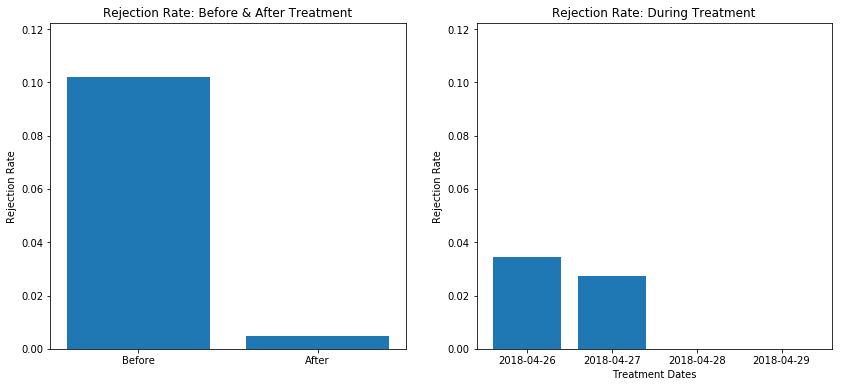

In [9]:
fig = plt.figure(figsize=(14, 6))
y_range = (0, max([before_rej_rate, after_rej_rate] + during_daily_rej_rates) * 1.2)

plt.subplot(1, 2, 1)
plt.title('Rejection Rate: Before & After Treatment')
plt.bar(['Before', 'After'], [before_rej_rate, after_rej_rate])
plt.ylabel('Rejection Rate')
plt.ylim(y_range)

plt.subplot(1, 2, 2)
plt.title('Rejection Rate: During Treatment')
plt.bar(treatment_dates, during_daily_rej_rates)
plt.xlabel('Treatment Dates')
plt.ylabel('Rejection Rate')
plt.ylim(y_range)

plt.savefig(user + '.png')
plt.show()
